# Intelligent Document Processing (IDP) with Amazon Nova Models

In this notebook, we demonstrate how to leverage Amazon Nova models along with the AWS Bedrock Converse API for Intelligent Document Processing (IDP). Our goal is to extract both unstructured summaries and structured data from PDF invoices. We cover several use cases:

- **Summarizing Content:** Extracting a brief summary and key insights from a single invoice.
- **Structured Data Extraction:** Using a custom tool configuration to force the model to output structured data from invoices that follow the same layout.
- **Generating Business Insights:** Aggregating data from multiple invoices to answer specific business questions.

This notebook assumes you are running the code with proper AWS credentials (preferably using an IAM role) and that you have enabled Amazon Bedrock models (in us-west-2) in your account. For more details on setting up temporary AWS credentials and enabling models, please refer to the provided documentation links.

**Notes:**
- Make sure you are running this code using your AWS Credentials. This notebook assumes you are loading the credentials using an IAM role, however, you may use your access_key if you are not using IAM Roles. For more details about how to set temporaty AWS credentials please check [this link](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_credentials_temp_use-resources.html).
- Before using Amazon Bedrock models in this notebook you need to enable them in your account in us-west-2, for more details about the steps required to enabled the model please check [this link](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access-modify.html).
- This notebook uses Amazon Nova Pro as default, all [charges on-demand on request basis](https://aws.amazon.com/bedrock/pricing/).
- Amazon Nova Pro will be used with the [Cross-Region Inference mode](https://docs.aws.amazon.com/bedrock/latest/userguide/cross-region-inference.html).
- While this notebook uses us-west-2 (Oregon), Amazon Nova is available in a variety of AWS Regions. Check our [document pages](https://docs.aws.amazon.com/bedrock/latest/userguide/models-regions.html) for more details about the regions available.

## Installing requirements

In [1]:
%pip install pip setuptools packaging -U --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install boto3 IPython --quiet

Note: you may need to restart the kernel to use updated packages.


Lets import our modules:

In [3]:
import boto3
import logging
from IPython.display import IFrame
from botocore.exceptions import ClientError
from pprint import pprint
import json

In [4]:
logging.basicConfig(level=logging.INFO,
                        format="%(levelname)s: %(message)s")

In [5]:
# Update this variable if you have enabled Amazon Nova in a different region
region_name = "us-west-2"

## 1. Summarizing Content: Extracting a brief summary and key insights from a single invoice.
In this use case we will use Amazon Nova models to process and extract data from PDF invoices using the Bedrock Converse API.

Here is our help function to load pdf and send requests to Amazon Bedrock using **Amazon Nova Pro**.

In [6]:
def send_document_to_bedrock(prompt, model_id="us.amazon.nova-pro-v1:0", file_path=None, tool_config=None, document_type=None):
    """
    Sends a message to the AWS Bedrock Converse API for processing, optionally including a PDF document.
    This function constructs a message that includes a text prompt and, if provided, a PDF document (as raw bytes)
    read from the specified file system path. It then sends the message to the AWS Bedrock Converse API using the provided
    model ID. Optionally, if a tool configuration is provided via the `tool_config` parameter, it is passed to the API call.
    The API response, which includes the model's output message and associated metadata, is returned.
    Parameters:
        prompt (str): A text prompt that provides context or instructions for processing.
        model_id (str): The identifier of the AWS Bedrock model to use for inference. This model must support document
            inputs. If no model_id is provided, Amazon Nova Pro will be used.
        file_path (str, optional): The file system path to the PDF document. If provided, the PDF will be read and
            included in the message. Defaults to None.
        tool_config (dict, optional): A dictionary specifying the tool configuration to be passed to the Converse API.
            Defaults to None.
        document_type (str): Document type, e.g., pdf, png.
    Returns:
        dict or None: The JSON response from the Bedrock Converse API if the call is successful, containing the model's
        output and metadata; returns None if an error occurs.
    Raises:
        ClientError: If there is an error invoking the AWS Bedrock Converse API.
    """
    # Build the content list starting with the prompt
    content_blocks = [{"text": prompt}]
    # If a PDF file path is provided, read the file and add a document block
    if file_path is not None:
        with open(file_path, "rb") as f:
            doc_bytes = f.read()
        if document_type == "pdf":
            content_blocks.append({
                "document": {
                    "name": "my_invoice_template",  # Use a neutral name
                    "format": "pdf",  # Supported formats: pdf | csv | doc | docx | xls | xlsx | html | txt | md
                    "source": {
                        "bytes": doc_bytes
                    }
                }
            })
        elif document_type == "png":
            content_blocks.append({
                "image": {
                    "format": "png",
                    "source": {"bytes": doc_bytes},
                }
            })
    # Initialize the Bedrock runtime client
    # Note: 'region_name' should be defined or replaced with your desired AWS region
    bedrock_client = boto3.client("bedrock-runtime", region_name=region_name)
    # Construct the message with the content blocks
    message = {
        "role": "user",
        "content": content_blocks
    }
    # Optional inference configuration parameters
    inference_config = {
        "maxTokens": 3000,
        "temperature": 0
    }
    try:
        # Build the parameters for the converse call
        converse_params = {
            "modelId": model_id,
            "messages": [message],
            "inferenceConfig": inference_config
        }
        # Include toolConfig if provided
        if tool_config is not None:
            converse_params["toolConfig"] = tool_config
        # Call the Converse API with the constructed parameters
        response = bedrock_client.converse(**converse_params)
        return response
    except ClientError as e:
        print("An error occurred:", e)
        return None

Here is how our test pdf looks like:

In [7]:
pdf_path = "invoices/test_invoice_0_1.pdf"
IFrame(pdf_path, width=600, height=900)

Lets extract a summary from one of our invoices:

In [8]:
prompt_text = "Please summarize the content of this PDF and share your insights in a list format."

result = send_document_to_bedrock(prompt=prompt_text, file_path=pdf_path, document_type="pdf")
if result:
    # Extract and print the text response from the model
    output_message = result.get("output", {}).get("message", {})
    for content in output_message.get("content", []):
        if "text" in content:
            print(content["text"])

INFO: Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


- The invoice is from the Sunset Hotel.
- Invoice number is 5331.
- The guest's name is Thomas Johnson DDS.
- The guest's address is 37618 Lee Keys, West Jenniferbury, MO 80214.
- The invoice date is January 14, 2022.
- There was 1 adult and no children or others staying.
- Charges include a guest room, laundry, dinner, breakfast, minibar, and taxi.
- The subtotal is $475.
- There is a $22 discount.
- Taxes amount to $40.20.
- The total amount due is $493.20.


## Structured Data Extraction: Using a custom tool configuration to force the model to output structured data from invoices that follow the same layout
Amazon Nova Pro was able to extract all the information present in our sample invoice. However, let’s improve our workflow by extracting data from our invoices using a custom blueprint and producing structured output. For this approach, we will use a custom tool, which is ideal if you need to force your model to produce structured output. In this sample code, we assume that all invoices follow the same layout; however, you can modify the prompts to dynamically extract data as well. First, we will ask Amazon Nova to generate our tool schema:

In [9]:
prompt_text_tool_builder="""
You are an expert to generate toolConfig for AWS Converse API. Your response must be a valid compact single-line JSON data structure and 
must contain the required toolConfig for a converse API tool to extract structured data from documents like my_invoice_template.
Here is a sample toolConfig, use my_invoice_template document to create the required toolConfig:
toolConfig={
        "tools": [
            {
                "toolSpec": {
                    "name": "weather",
                    "description": "Use this tool if the request is to get the previous, current, or future weather for a country",
                    "inputSchema": {
                        "json": {
                            "type": "object",
                            "properties": {
                                "country": {
                                    "type": "string"
                                },
                                "dates": {
                                    "type": "object",
                                    "properties": {
                                        "date_start": {
                                            "type": "string",
                                            "format": "date"
                                        },
                                        "date_end": {
                                            "type": "string",
                                            "format": "date"
                                        }
                                    },
                                    "required": [
                                        "date_start",
                                        "date_end"
                                    ]
                                }
                            },
                            "required": [
                                "country",
                                "dates"
                            ]
                        }
                    }
                }
            }
        ],
        "toolChoice": {
            "auto": {}
        }
    }
Please perform the requested task and return the result in JSON format. Follow these rules exactly:
- Output only a valid JSON object/array with the specified content – no surrounding text, no explanations.
- Ensure the JSON is syntactically correct: use double quotes for all keys and string values, include all 
    required commas and quotes, and close all brackets and braces properly (no missing { } or [ ]).
- The JSON must be on a single line (compact format) without any line breaks or markdown formatting. 
    Do not use triple backticks or code blocks – just raw JSON.
- Use the exact JSON structure required for the answer.
Now, using the information provided, generate the answer as JSON following the above requirements and schema. 
Do NOT include any text outside the JSON structure.
"""

In [10]:
result = send_document_to_bedrock(prompt=prompt_text_tool_builder, file_path=pdf_path, document_type="pdf")
if result:
    # Extract and print the text response from the model
    output_message = result.get("output", {}).get("message", {})
    for content in output_message.get("content", []):
        if "text" in content:
            tools = content["text"]
            print(tools)

{"tools":[{"toolSpec":{"name":"extract_invoice_data","description":"Use this tool to extract structured data from an invoice document.","inputSchema":{"json":{"type":"object","properties":{"invoice_number":{"type":"string"},"guest_name":{"type":"string"},"date_of_issue":{"type":"string","format":"date"},"guest_address":{"type":"string"},"no_of_adults":{"type":"integer"},"no_of_children":{"type":"integer"},"others":{"type":"integer"},"items":{"type":"array","items":{"type":"object","properties":{"no":{"type":"integer"},"date":{"type":"string","format":"date"},"description":{"type":"string"},"amount":{"type":"number"}}},"minItems":1},"subtotal":{"type":"number"},"discounts":{"type":"number"},"taxes":{"type":"number"},"total":{"type":"number"}},"required":["invoice_number","guest_name","date_of_issue","guest_address","no_of_adults","no_of_children","others","items","subtotal","discounts","taxes","total"]}}}}],"toolChoice":{"auto":{}}}


It is time to use our `send_document_to_bedrock` function again but this time adding our new tool.

In [11]:
prompt_text = "Please summarize the content of this PDF and share your insights."
# Document list
document_list = []

# Lets add another helper function
def update_document_list(prompt, file_path, tools, document_type, document_list):
    """
    This function updates the document list by sending the prompt and file path to the Bedrock model.
    It then extracts the toolUse input from the model's response and appends it to the document list.

    Args:
        prompt (str): The prompt to be sent to the Bedrock model.
        file_path (str): The path to the file to be sent to the Bedrock model.
        tools (str): The tools configuration for the Bedrock model.
        document_type (str): The type of document being processed.
        document_list (list): The list to which the extracted toolUse input will be appended.

    Returns:
        None
    """
    result = send_document_to_bedrock(
        prompt=prompt,
        file_path=file_path,
        tool_config=eval(tools),  # pass the dictionary, not a string
        document_type=document_type)
    if result:
        # Extract and print the text response from the model
        output_message = result.get("output", {}).get("message", {})
        for content in output_message.get("content", []):
            if "toolUse" in content:
                pprint(content["toolUse"]["input"])
                # We will store the extracted information in our list
                document_list.append(content["toolUse"]["input"])

update_document_list(prompt=prompt_text, file_path=pdf_path, tools=tools, document_type="pdf", document_list=document_list)

{'date_of_issue': '2022-01-14',
 'discounts': 22.0,
 'guest_address': '37618 Lee Keys West Jenniferbury, MO 80214',
 'guest_name': 'Thomas Johnson DDS',
 'invoice_number': '5331',
 'items': [{'amount': 180.0,
            'date': '2022-01-14',
            'description': 'Guest room',
            'no': 1},
           {'amount': 15.0,
            'date': '2022-01-14',
            'description': 'Laundry',
            'no': 2},
           {'amount': 70.0,
            'date': '2022-01-14',
            'description': 'Dinner',
            'no': 3},
           {'amount': 30.0,
            'date': '2022-01-14',
            'description': 'Breakfast',
            'no': 4},
           {'amount': 90.0,
            'date': '2022-01-14',
            'description': 'Minibar',
            'no': 5},
           {'amount': 90.0,
            'date': '2022-01-14',
            'description': 'Taxi',
            'no': 6}],
 'no_of_adults': 1,
 'no_of_children': 0,
 'others': 0,
 'subtotal': 475.0,
 'taxes':

We will now extract the information from a second document using the same tool created by Nova, and add the document to our list.

In [12]:
# here is a different invoice
pdf_path="invoices/test_invoice_0_2.pdf"

update_document_list(prompt=prompt_text, file_path=pdf_path, tools=tools, document_type="pdf", document_list=document_list)

{'date_of_issue': '2021-04-21',
 'discounts': 24,
 'guest_address': '73065 Amanda Forges Crossbyside, AL 81369',
 'guest_name': 'Michaela Johns',
 'invoice_number': '9582',
 'items': [{'amount': 180,
            'date': '2021-04-19',
            'description': 'Guest room',
            'no': 1},
           {'amount': 30,
            'date': '2021-04-19',
            'description': 'Breakfast',
            'no': 2},
           {'amount': 180,
            'date': '2021-04-20',
            'description': 'Guest room',
            'no': 3},
           {'amount': 15,
            'date': '2021-04-20',
            'description': 'Laundry',
            'no': 4},
           {'amount': 70,
            'date': '2021-04-20',
            'description': 'Dinner',
            'no': 5},
           {'amount': 30,
            'date': '2021-04-20',
            'description': 'Breakfast',
            'no': 6},
           {'amount': 180,
            'date': '2021-04-21',
            'description': 'Guest r

In [13]:
# Here is the second PDF
IFrame(pdf_path, width=600, height=900)

We have two documents in our list now:

In [14]:
print(f'Document count: {len(document_list)}')

Document count: 2


## Generating Business Insights: Aggregating data from multiple invoices to answer specific business questions
We have used Amazon Nova to create a custom blueprint using a tool for the Converse API and also extracted data from 2 documents using the same blueprint. We will interrogate our data and generate insights with the following questions:
1. What guest spent the most in the hotel?
2. What guest spent the least nights in the hotel?

In [15]:
user_questions="""
1. What guest spent the most in the hotel?
2. What guest spent the least nights in the hotel?
"""

prompt_extracting_insights=f"""
You are a business analysist specialiased to extract information from invoices. You will be provided with a list of invoices, 
answer the user question using only information present in your list of invoices. Your response must be in raw text.
User question: {user_questions}
List of invoices: {document_list}
"""

In [16]:
def business_insights(prompt=prompt_extracting_insights):
    result = send_document_to_bedrock(prompt=prompt)
    if result:
        # Extract and print the text response from the model
        output_message = result.get("output", {}).get("message", {})
        for content in output_message.get("content", []):
            if "text" in content:
                print(content["text"])
business_insights()

1. The guest who spent the most in the hotel is Michaela Johns with a total of 844.9.
2. The guest who spent the least nights in the hotel is Thomas Johnson DDS with 1 night.


## 2. Summarizing Content: Extracting a brief summary and key insights from a single invoice (image).
We also have some files which are scanned images of physical invoices, Amazon Nova can also work with image files. Now we will use Amazon Nova models to process and extract data from image files using the Bedrock Converse API.

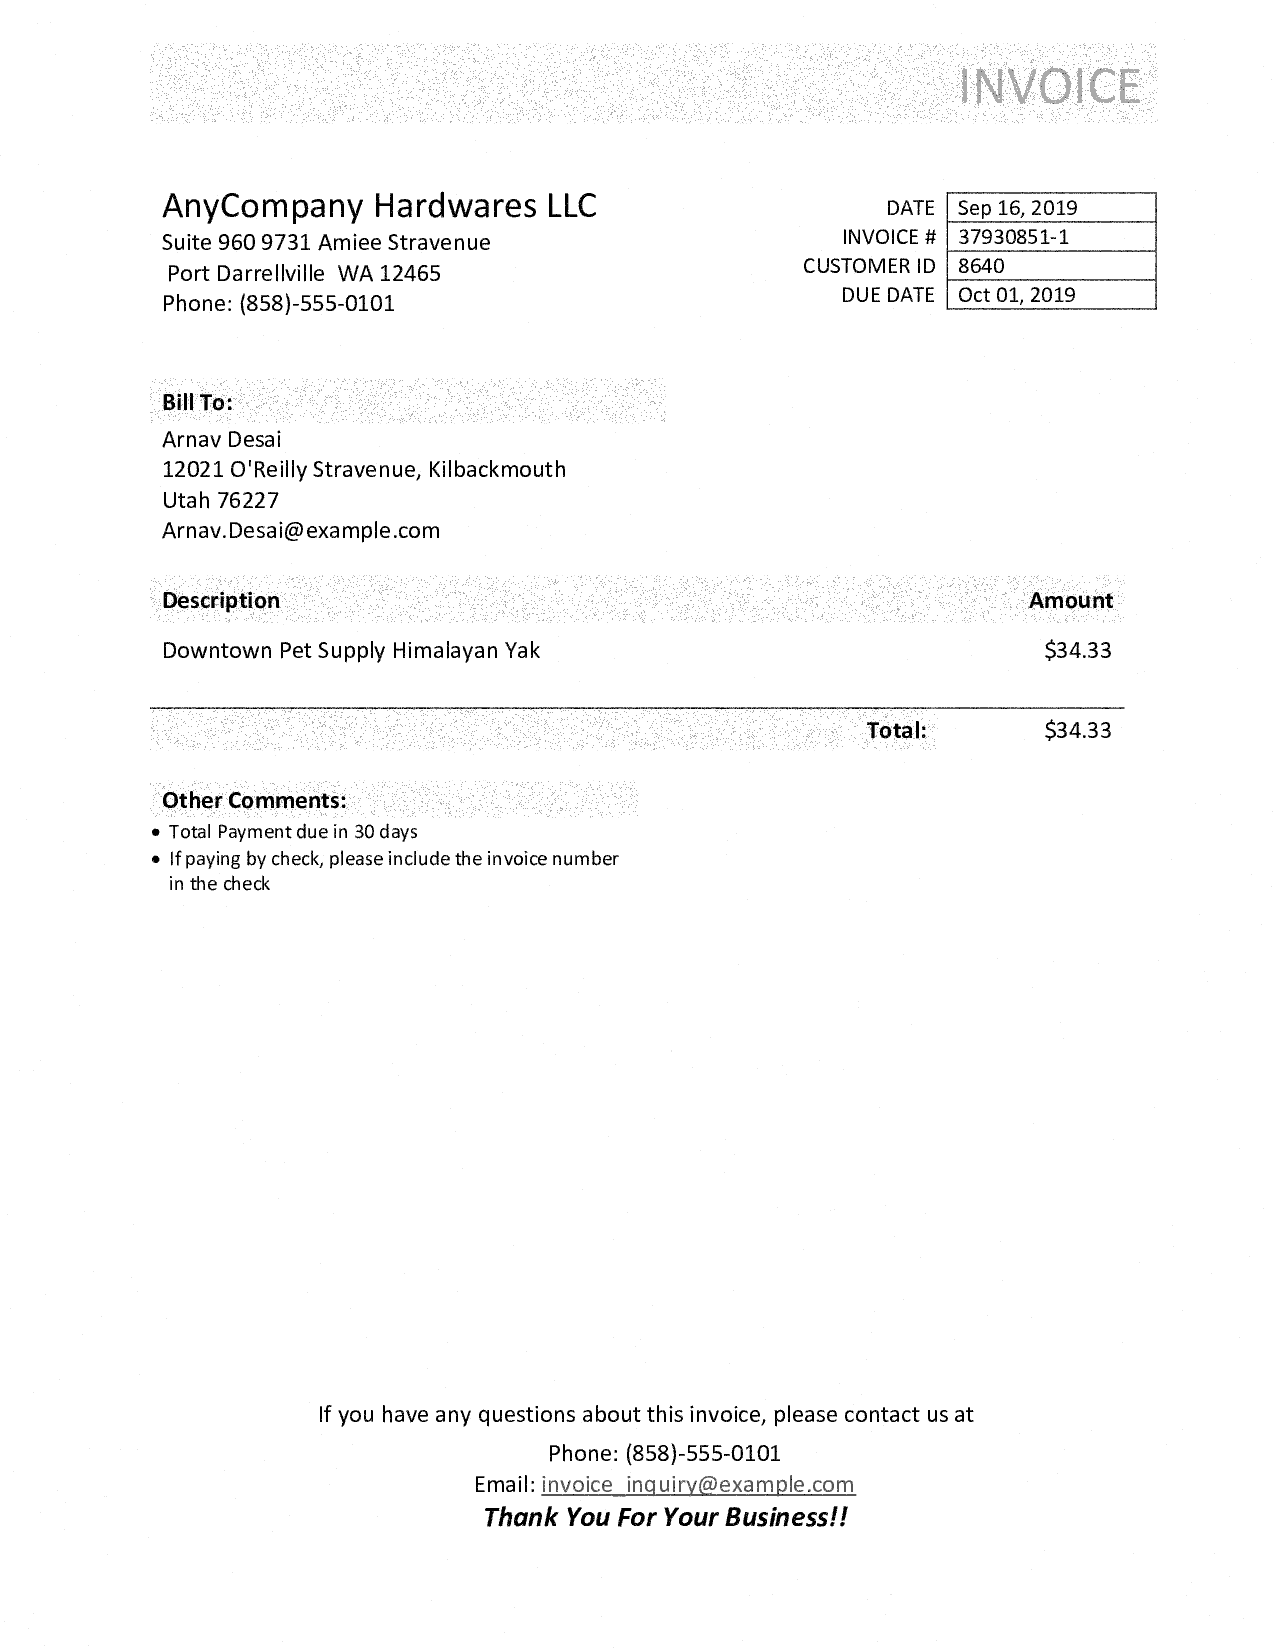

In [17]:
from IPython.display import display, Image

# here is the first invoice
image_path = "invoices/invoice_0.png"
display(Image(filename=image_path))

Lets go over the same exercise, first we will extract unstructured insights from our invoice and then later retrieve a structured output in JSON.

In [18]:
prompt_text = "Please summarize the content of this image and share your insights in a list format."

# notice we are still using the same function but we are providing "png" as document type
result = send_document_to_bedrock(prompt=prompt_text, file_path=image_path, document_type="png")
if result:
    # Extract and print the text response from the model
    output_message = result.get("output", {}).get("message", {})
    for content in output_message.get("content", []):
        if "text" in content:
            print(content["text"])

- The document is an invoice from AnyCompany Hardwares LLC.
- The invoice number is 37930851-1.
- The invoice date is September 16, 2019.
- The customer ID is 8640.
- The due date for payment is October 1, 2019.
- The invoice is addressed to Arnav Desai at 12021 O'Reilly Stravenue, Kilbackmouth, Utah 76227.
- The contact email for the recipient is Arnav.Desai@example.com.
- The description of the service provided is "Downtown Pet Supply Himalayan Yak."
- The amount charged for the service is $34.33.
- The total amount due is $34.33.
- Payment terms indicate that the total payment is due within 30 days.
- If paying by check, the invoice number should be included in the check.
- Contact information for inquiries is provided as Phone: (858)-555-0101 and Email: invoice.inquiry@example.com.
- The document concludes with a thank you message for the customer's business.


## Structured Data Extraction: Using a custom tool to force the model to output structured data from image invoices
Since Amazon Nova generated a tool capable of extracting data from PDF, we can use that as an example for our image blueprints.

In [19]:
improved_prompt_text_tool_builder="""
You are an expert to generate toolConfig for AWS Converse API. Your response must be a valid compact single-line JSON data structure and 
must contain the required toolConfig for a converse API tool to extract structured data from documents like my_invoice_template.
Here is a sample toolConfig, use my_invoice_template document to create the required toolConfig:
toolConfig={
    "tools": [
        {
            "toolSpec": {
                "name": "extract_invoice_data",
                "description": "Use this tool to extract structured data from an invoice document.",
                "inputSchema": {
                    "json": {
                        "type": "object",
                        "properties": {
                            "invoice_number": {
                                "type": "string"
                            },
                            "guest_name": {
                                "type": "string"
                            },
                            "date_of_issue": {
                                "type": "string",
                                "format": "date"
                            },
                            "guest_address": {
                                "type": "string"
                            },
                            "no_of_adults": {
                                "type": "integer"
                            },
                            "no_of_children": {
                                "type": "integer"
                            },
                            "others": {
                                "type": "integer"
                            },
                            "items": {
                                "type": "array",
                                "items": {
                                    "type": "object",
                                    "properties": {
                                        "no": {
                                            "type": "integer"
                                        },
                                        "date": {
                                            "type": "string",
                                            "format": "date"
                                        },
                                        "description": {
                                            "type": "string"
                                        },
                                        "amount": {
                                            "type": "number"
                                        }
                                    }
                                },
                                "minItems": 1
                            },
                            "subtotal": {
                                "type": "number"
                            },
                            "discounts": {
                                "type": "number"
                            },
                            "taxes": {
                                "type": "number"
                            },
                            "total": {
                                "type": "number"
                            }
                        },
                        "required": [
                            "invoice_number",
                            "guest_name",
                            "date_of_issue",
                            "guest_address",
                            "no_of_adults",
                            "no_of_children",
                            "others",
                            "items",
                            "subtotal",
                            "discounts",
                            "taxes",
                            "total"
                        ]
                    }
                }
            }
        }
    ],
    "toolChoice": {
        "auto": {}
    }
}
Please perform the requested task and return the result in JSON format. Follow these rules exactly:
- Output only a valid JSON object/array with the specified content – no surrounding text, no explanations.
- Ensure the JSON is syntactically correct: use double quotes for all keys and string values, include all 
    required commas and quotes, and close all brackets and braces properly (no missing { } or [ ]).
- The JSON must be on a single line (compact format) without any line breaks or markdown formatting. 
    Do not use triple backticks or code blocks – just raw JSON.
- Use the exact JSON structure required for the answer.
Now, using the information provided, generate the answer as JSON following the above requirements and schema. 
Do NOT include any text outside the JSON structure.
"""

In [20]:
# It is time to use our new prompt, set the document type as png and use our new invoice (image)
result = send_document_to_bedrock(prompt=improved_prompt_text_tool_builder, file_path=image_path, document_type="png")
if result:
    # Extract and print the text response from the model
    output_message = result.get("output", {}).get("message", {})
    for content in output_message.get("content", []):
        if "text" in content:
            tools = content["text"]
            print(tools)

{"tools":[{"toolSpec":{"name":"extract_invoice_data","description":"Use this tool to extract structured data from an invoice document.","inputSchema":{"json":{"type":"object","properties":{"invoice_number":{"type":"string"},"customer_id":{"type":"string"},"date":{"type":"string","format":"date"},"due_date":{"type":"string","format":"date"},"bill_to":{"type":"string"},"description":{"type":"string"},"amount":{"type":"number"},"total":{"type":"number"}},"required":["invoice_number","customer_id","date","due_date","bill_to","description","amount","total"]}}}}],"toolChoice":{"auto":{}}}


It is time to test our new blueprint/tool with images.

In [26]:
# Please note we are setting a new list for our images
prompt_text = "Please summarize the content of this PDF and share your insights."
image_list = []

update_document_list(prompt=prompt_text, file_path=image_path, tools=tools, document_type="png", document_list=image_list)

{'amount': 49.36,
 'bill_to': 'Jorge Souza\n'
            '2260 Blick Lakes, Maryrosecchester\n'
            'South Carolina 24084\n'
            'Jorge.Souza@example.com',
 'customer_id': '9485',
 'date': 'Dec 25, 2018',
 'description': 'Tripar 25 in. Metal Display',
 'due_date': 'Jan 09, 2019',
 'invoice_number': '63662111-0',
 'total': 49.36}


Lets add a second document to our list.

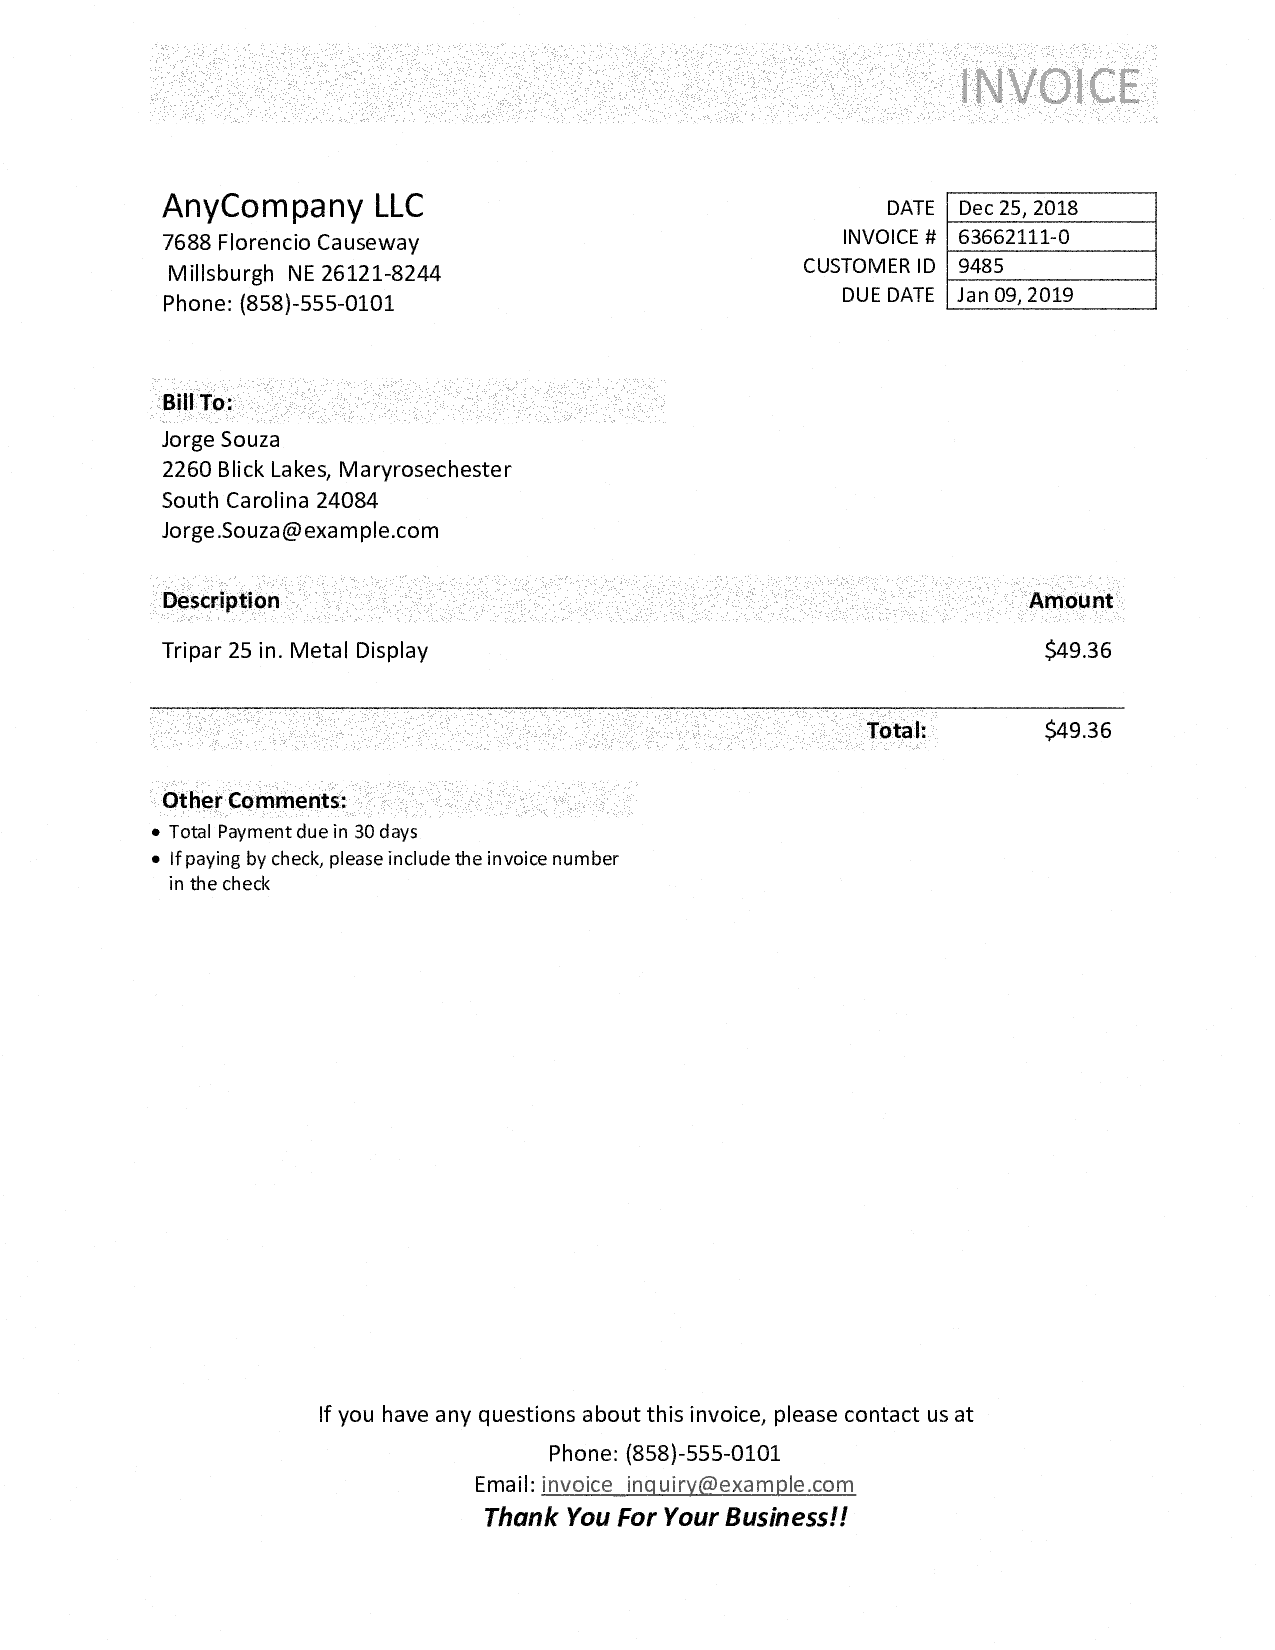

In [22]:
#Lets check our image
image_path = "invoices/invoice_1.png"
display(Image(filename=image_path))

In [27]:
update_document_list(prompt=prompt_text, file_path=image_path, tools=tools, document_type="png", document_list=image_list)

{'amount': 49.36,
 'bill_to': 'Jorge Souza\n'
            '2260 Blick Lakes, Maryrosecchester\n'
            'South Carolina 24084\n'
            'Jorge.Souza@example.com',
 'customer_id': '9485',
 'date': 'Dec 25, 2018',
 'description': 'Tripar 25 in. Metal Display',
 'due_date': 'Jan 09, 2019',
 'invoice_number': '63662111-0',
 'total': 49.36}


## Generating Business Insights from scanned documents

In [28]:
new_user_questions="""
1. Who spent the most?
2. What is our oldest invoice? I need the invoice number.
"""

# Using the same prompt with a different set of questions and documents
prompt_extracting_insights=f"""
You are a business analysist specialiased to extract information from invoices. You will be provided with a list of invoices, 
answer the user question using only information present in your list of invoices. Your response must be in raw text.
User question: {new_user_questions}
List of invoices: {image_list}
"""

In [29]:
business_insights(prompt=prompt_extracting_insights)

1. Jorge Souza spent the most with an amount of 49.36.
2. The oldest invoice in the list is from Dec 25, 2018, and the invoice number is 63662111-0.
